<h1>Tutorial: Bayesian Optimization Explanation for Beginners</h1>


<h1>Bayesian Optimization Overview</h1>

Optimizing a non-linear function $f(\mathbf{x})$ within a compact set $\mathcal{A}$ is of great scientific interest due to its versatility and real-world applicability. However, problems arise when the function has no closed-form analytical solution or is computationally expensive to evaluate. This gives rise to Bayesian optimization to mitigate such problems.

$$
\max _{\mathbf{x} \in \mathcal{A} \subset \mathbb{R}^d} f(\mathbf{x})
$$

Bayesian optimization is a surrogate-based optimization strategy, typically using a Gaussian process regression model to approximate the unknown function. This strategy is particularly useful when the objective function is difficult to evaluate. Initially, we have some prior beliefs about the objective function. As we accumulate more information, $\mathcal{D}_{1: t}=\left\{\mathbf{x}_{1: t}, f\left(\mathbf{x}_{1: t}\right)\right\}$, we obtain a posterior distribution of the function, $P\left(f \mid \mathcal{D}{1}\right)$, which facilitates optimization.

$$
P\left(f \mid \mathcal{D}_{1: t}\right) \propto P\left(\mathcal{D}_{1: t} \mid f\right) P(f)
$$

Given a Gaussian process regression model that provides a posterior mean $\mu(\mathbf{x})$ and a posterior covariance $\Sigma(\mathbf{x})$ for the objective function $f(\mathbf{x})$, the next sampling point $\mathbf{x}_{t+1}$ is chosen by maximizing an acquisition function $u(\mathbf{x}\mid \mathcal{D})$ that balances exploration and exploitation.

$$
\mathbf{x}_{\text{next}} = \underset{\mathbf{x} \in \mathcal{A}}{\arg\max} \, u(\mathbf{x}\mid \mathcal{D})
$$

>This tutorial is adapted from several resources:
>- The paper *A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning* ([link](https://doi.org/10.48550/arXiv.1012.2599)), which provides an in-depth introduction to Bayesian optimization.
>- A Bayesian optimization notebook on Colab ([link](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-optimization/bayesian_optimization.ipynb)), which walks through practical implementations in Python.
>- A GitHub post on acquisition functions ([link](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)), offering a clear explanation of acquisition functions in Bayesian optimization.

In [1]:
# This notebook mostly uses the fundamental libraries, e.g. numpy to illustrate the inner workings of Bayesian optimization.
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import warnings
import copy

<h2> Arbitrary True "Black-Box" Objective function Function </h2>

In Bayesian optimization, we often deal with an unknown or "black box" objective function that we aim to model. This function can be complex and is not explicitly defined, making it challenging to analyze directly.

$$
f(x) = -\sin(3x) + x^2 + 0.7x + \varepsilon \quad \text{for} \quad x \in [-1, 2]
$$

In [2]:
def black_box_function(X_train, noise):
    return -np.sin(3*X_train) - X_train**2 + 0.7*X_train + noise * np.random.randn(len(X_train), 1)

This plot shows a black box objective function with two distinct local maxima (peaks).

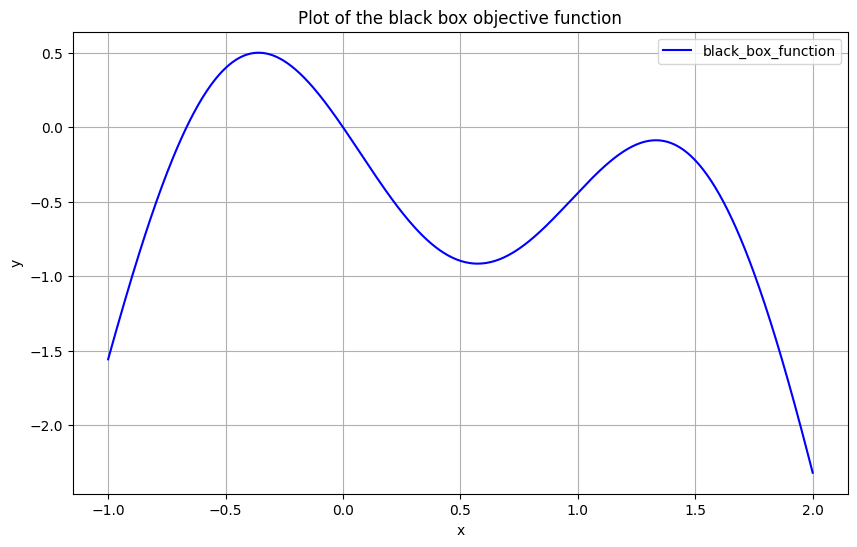

In [3]:
x_plot = np.linspace(-1, 2, 500).reshape(-1, 1)
y_plot = black_box_function(x_plot, noise=0)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_plot, label="black_box_function", color="b")
plt.title("Plot of the black box objective function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

<h1> Gaussian Process Regression Model </h1>

From the structure of the regression model, the posterior distribution of the testing dataset given training dataset is as follows: 

\begin{equation*}
y=h\left(x\right)+\varepsilon
\end{equation*}

\begin{equation*}
\begin{bmatrix}
    \vec{y}_{train} \\
    \vec{y}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test} =
\begin{bmatrix}
    \vec{h}_{train} \\
    \vec{h}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test}
+ 
\begin{bmatrix}
    \vec{\epsilon}_{train} \\
    \vec{\epsilon}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test}
\sim \mathcal{N} \left( 
\vec{0},
\begin{bmatrix}
    K(X_{train}, X_{train}) + \sigma^2 I & K(X_{train}, X_{test}) \\
    K(X_{test}, X_{train}) & K(X_{test}, X_{test}) + \sigma^2 I
\end{bmatrix}
\right)
\end{equation*}

Remember in the basic statistics review, the posterior distribution of normally distributed variable given another normally distributed variable has a known form of expression

\begin{equation*}
\vec{y}_{test} \mid \vec{y}_{train}, X_{train}, X_{test} \sim \mathcal{N}(\mu^*, \Sigma^*)
\end{equation*}

where

\begin{align*}
\mu^* &= K(X_{test}, X_{train})(K(X_{train}, X_{train}) + \sigma^2 I)^{-1} \vec{y} \\
\Sigma^* &= K(X_{test}, X_{test}) + \sigma^2 I - K(X_{test}, X_{train})(K(X_{train}, X_{train}) + \sigma^2 I)^{-1} K(X_{train}, X_{test})
\end{align*}


In [4]:
class GaussianProcessRegression:

    def __init__(self, noise_variance=1e-8, length_scale=1.0):
        self.noise_variance = noise_variance
        self.length_scale = length_scale
        self.X_train, self.y_train = None, None
        self.K = None
        self.func_mu, self.func_cov = None, None

    # Radial Basis Kernel
    def rbf_kernel(self, X1, X2):
        sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-0.5 * sqdist / self.length_scale**2)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.K = self.rbf_kernel(self.X_train, self.X_train) + self.noise_variance * np.eye(len(self.X_train))

    # GPR posterior distribution prediction of mean and covariance function
    def predict(self, X_test):
        # Covariance between training and test points
        K_s = self.rbf_kernel(self.X_train, X_test)
        # Covariance for the test points
        K_ss = self.rbf_kernel(X_test, X_test) + self.noise_variance * np.eye(len(X_test))
        

        # Compute the mean of the predictive distribution
        K_inv = np.linalg.inv(self.K)
        self.func_mu = K_s.T @ K_inv @ self.y_train
        # Compute the variance of the predictive distribution
        self.func_cov = K_ss - K_s.T @ K_inv @ K_s
        
        return self.func_mu, self.func_cov
    
    # Visualization of predictions
    def plot_gp(self, X_test, mu_s, cov_s):

        # Mean prediction
        mu_s = mu_s.ravel()
        # Confidence intervals
        uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
        
        plt.figure(figsize=(10, 6))
        # Plot training data
        plt.plot(self.X_train, self.y_train, 'kx', label='Training Data')
        # Plot GP mean
        plt.plot(X_test, mu_s, 'b', lw=2, label='Mean Prediction')
        # plt.plot(X_test,  np.sin(X_test), 'k', lw=2, label='True Function')
        plt.plot(X_test,  black_box_function(X_test,0), 'k', lw=2, label='True Function')
        
        # Plot uncertainty bounds
        plt.fill_between(X_test.ravel(), mu_s - uncertainty, mu_s + uncertainty, 
                        color='blue', alpha=0.2, label='Confidence Interval')
        
        plt.ylim([-2,2])
        plt.title('Gaussian Process Regression')
        plt.legend()
        plt.show()

In [5]:
# Generating synthetic data
def generate_data( black_box_function, range = [-5,5], n_samples=10, noise=0.1):
    X_train = np.random.uniform(range[0], range[1], n_samples).reshape(-1, 1)
    y_train = black_box_function(X_train, noise)
    return X_train, y_train

<h1> Acquisition Function </h1>

Acquisition functions are generally designed so that high values indicate a potential for high objective function values, either due to a strong prediction, high uncertainty, or a combination of both. The next point to evaluate the objective function is chosen by maximizing the acquisition function. In other words, we aim to sample $ f $ at the point $u(\mathbf{x} \mid \mathcal{D})$, where $ u(\cdot) $ represents the acquisition function.

<h3> Upper Confidence Bound </h3>

The Upper Confidence Bound (UCB) function is an acquisition function used in Bayesian optimization to guide the selection of the next sampling point for evaluating an objective function. It is defined as $ u(\mathbf{x} \mid \mathcal{D}) = \mu(\mathbf{x} \mid \mathcal{D}) + \lambda \sigma(\mathbf{x} \mid \mathcal{D}) $, where $ \mu $ is the posterior mean and \( \sigma \) is the posterior standard deviation provided by a Gaussian process model, and $ \lambda $ is a hyperparameter that controls the trade-off between exploration and exploitation. A lower $ \lambda $ emphasizes exploitation, favoring sampling points with high predicted values based on existing data, while a higher $ \lambda $ increases the emphasis on exploration, encouraging sampling in regions of high uncertainty to discover potentially better solutions. This flexibility in tuning $ \lambda $ allows the UCB function to efficiently navigate complex optimization landscapes by balancing the need to refine knowledge in promising areas with the need to explore new possibilities.

$$
u(\mathbf{x} \mid \mathcal{D}) = \text{UCB}(\mathbf{x}\mid \mathcal{D}; \lambda) = \mu(\mathbf{x} \mid \mathcal{D}) + \lambda \sigma(\mathbf{x} \mid \mathcal{D})
$$

<h2> Improvement-based Acquisition Function (For Univariate Problems) </h2>


- Note: Full derivation can be found in the Appendix Section

<h3> Probability of Improvement </h3>

Before introducing the Probability of Improvement function, we first define the improvement function $I(\mathbf{x}) = \max \left(f(\mathbf{x}) - f\left(\mathbf{x}^{+}\right), 0\right)$, which is the difference between the surrogate function $ f(\mathbf{x}) $ and the best sampled value $\mathbf{x}^{+}=\operatorname{argmax}_{\mathbf{\mathbf{x}}_i \in \mathbf{x}_{1: t}} f\left(\mathbf{x}_i\right)$, with a lower bound of zero. A reparametrization technique can transform $f(\mathbf{x})$ into the form $f(\mathbf{x}) = \mu(x \mid \mathcal{D}) + \sigma(x \mid \mathcal{D}) z,$ where $z$ is a standard normal random variable.

$$
I(\mathbf{x}) = \max \left(f(\mathbf{x}) - f\left(\mathbf{x}^{+}\right) - \xi, 0\right) = \max \left(\mu(\mathbf{x}\mid \mathcal{D}) + \sigma(\mathbf{x}\mid \mathcal{D}) z - f\left(\mathbf{x}^{+}\right) - \xi, 0\right) \quad \text{where} \quad z \sim \mathcal{N}(0, 1)
$$

The Probability of Improvement function is also called the MPI (Maximum Probability of Improvement) or the P function; it aims to select a point that improves upon the best sampled point $ \mathbf{x}^{+} $ by at least $ \xi $.

$$
\begin{aligned}
\mathrm{PI}(\mathbf{x}) & =P\left(I(\mathbf{x}) \geq 0\right)  =\Phi\left(\frac{\mu(\mathbf{x}\mid \mathcal{D})-f\left(\mathbf{x}^{+}\right)-\xi}{\sigma(\mathbf{x}\mid \mathcal{D})}\right)
\end{aligned}
$$

<h3> Expected Improvement </h3>

An alternative acquisition function would take into account both the probability of improvement and the magnitude of improvement. The function $ u(\mathbf{x} \mid \mathcal{D}) $ would represent the expected value of the improvement function:

$$
\mathrm{EI}(\mathbf{x}) = \mathbb{E}\left( I(\mathbf{x}) \mid \mathcal{D}\right) = \mathbb{E}\left(\max \left\{0, f_{t+1}(\mathbf{x})-f\left(\mathbf{x}^{+}\right)\right\} \mid \mathcal{D}\right)
$$

A very nice closed-form solution can be derived from integrating the improvement function multiplied by the Gaussian distribution function

$$
\mathrm{EI}(\mathbf{x}) = \begin{cases} 
(\mu(\mathbf{x}\mid \mathcal{D}) - f(\mathbf{x}^+) - \xi)\Phi(Z) + \sigma(\mathbf{x}\mid \mathcal{D})\phi(Z) & \text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) > 0 \\ 
0 & \text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) = 0 
\end{cases}
$$

where

$$
Z =
\begin{cases}
\frac{\mu(\mathbf{x}\mid \mathcal{D}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x}\mid \mathcal{D})} &\text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) = 0
\end{cases}
$$

In [6]:
class AcquisitionFunction:

    def __init__(self):
        pass

    def get_function(self, name=None):
        self.name = name

        if self.name == "expected_improvement":
            return self.expected_improvement
        elif self.name == "probability_of_improvement":
            return self.probability_of_improvement
        elif self.name == "upper_confidence_bound":
            return self.upper_confidence_bound
        else:
            warnings.warn(f"Warning: '{self.name}' is not a valid option. Returning None.")
            return None

    def expected_improvement(self, X, X_sample, gpr, xi=0.01):
        mu_domain, cov_domain = gpr.predict(X)
        sigma_domain = np.sqrt(np.diag(cov_domain))
        sigma_domain = sigma_domain.flatten()
        
        mu_sample, _ = gpr.predict(X_sample)
        mu_sample_optimal = np.max(mu_sample)

        with np.errstate(divide="warn"):
            improvement = mu_domain - mu_sample_optimal - xi
            improvement = improvement.flatten()
            Z = improvement/sigma_domain
            
            ei = improvement * norm.cdf(Z) + sigma_domain * norm.pdf(Z)
            ei[sigma_domain == 0.0] = 0.0

        return ei
    
    def probability_of_improvement(self, X, X_sample, gpr, xi=0.01):
        mu_domain, cov_domain = gpr.predict(X)
        sigma_domain = np.sqrt(np.diag(cov_domain))
        sigma_domain = sigma_domain.flatten()
        
        mu_sample, _ = gpr.predict(X_sample)
        mu_sample_optimal = np.max(mu_sample)

        with np.errstate(divide="warn"):
            improvement = mu_domain - mu_sample_optimal - xi
            improvement = improvement.flatten()
            Z = improvement/sigma_domain
            
            pi = norm.cdf(Z)
            # pi[sigma_domain == 0.0] = 0.0

        return pi

    def upper_confidence_bound(self, X, X_sample, gpr, lamb=0.1):
        mu_domain, cov_domain = gpr.predict(X)
        sigma_domain = np.sqrt(np.diag(cov_domain))
        sigma_domain = sigma_domain.flatten()
        
        alpha = mu_domain.flatten() + lamb*sigma_domain
        alpha = alpha.flatten()

        return alpha

In [7]:
class PlottingHelper:
    def __init__(self, bayesian_optimization_instance):
        self.bo_instance = bayesian_optimization_instance
        self.scale = 0.6

    def plot_insight(self, X_next):
        gpr = self.bo_instance.gpr
        X_test = self.bo_instance.X_test
        black_box_function = self.bo_instance.black_box_function
        name = self.bo_instance.name
        objective_function = self.bo_instance.objective_function

        mu_s, cov_s = gpr.predict(X_test)
        # Mean prediction
        mu_s = mu_s.ravel()
        # Confidence intervals (95%)
        uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
        
        # Set up the figure and two subplots (1 row, 2 columns)
        plt.figure(figsize=(14*self.scale, 6*self.scale))  # Adjust the figure size for better readability
        
        # Left plot: Gaussian Process Regression
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        # Plot training data
        plt.plot(self.bo_instance.X_train, self.bo_instance.y_train, 'kx', label='Training Data')
        # Plot GP mean
        plt.plot(X_test, mu_s, 'b', lw=2, label='Mean Prediction')
        # Plot true function
        plt.plot(X_test, black_box_function(X_test, 0), 'k', lw=2, label='True Function')
        # Plot uncertainty bounds (Confidence interval)
        plt.fill_between(X_test.ravel(), mu_s - uncertainty, mu_s + uncertainty, 
                         color='blue', alpha=0.2, label='Confidence Interval')

        if X_next is not None:
            plt.axvline(x=X_next, color='black', linestyle='--', lw=2)

        plt.ylim([-2, 2])
        plt.title('Gaussian Process Regression')
        plt.legend()

        # Right plot: Acquisition Function (AF)
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        acquisition_function_values = -objective_function(X_test)
        plt.plot(X_test, acquisition_function_values, 'r', lw=2, label="Acquisition Function")

        if X_next is not None:
            plt.axvline(x=X_next, color='black', linestyle='--', lw=2, label="Next sampling point")
        plt.title(f'Acquisition Function ("{name}")')
        plt.xlabel('X')
        plt.ylabel(name)
        plt.legend()

        # Show the plot
        plt.tight_layout()  # Adjusts the spacing between the two subplots
        plt.show()

    def plot_3d_evolution(self, X_next_list, iteration_list, gpr_list):
        X_test = self.bo_instance.X_test
        black_box_function = self.bo_instance.black_box_function
        objective_function = self.bo_instance.objective_function

        fig = plt.figure(figsize=(14*self.scale, 6*self.scale))
        
        # Create a 3D subplot for Gaussian Process Regression
        ax1 = fig.add_subplot(121, projection='3d')
        
        for idx, X_next in enumerate(X_next_list):
            model = gpr_list[idx]
            # Get predictions and uncertainty for this iteration
            mu_s, cov_s = model.predict(X_test)
            mu_s = mu_s.ravel()
            uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
            
            # Plot training data at this iteration
            ax1.scatter(model.X_train, [iteration_list[idx]], model.y_train, 
                        color='k', label='Training Data' if idx == 0 else "", zorder=5)
            
            # Plot GP mean prediction at this iteration
            ax1.plot(X_test, [iteration_list[idx]] , mu_s.reshape(X_test.shape), color='b', lw=2, 
                     label='Mean Prediction' if idx == 0 else "")
            
            ax1.plot(X_test, [iteration_list[idx]] , black_box_function(X_test, 0).reshape(X_test.shape), color='k', lw=2, 
                     label='Mean Prediction' if idx == 0 else "")
            
            # Plot the surfaces for the confidence interval
            Y_iteration = np.full_like(X_test, iteration_list[idx]).ravel()

            # Prepare 2D arrays for plotting
            X_test_mesh = np.array([X_test.ravel(), X_test.ravel()])
            Y_iteration_mesh = np.array([Y_iteration, Y_iteration])
            
            # Plot the upper and lower bounds as surfaces
            upper_bound = mu_s + uncertainty
            lower_bound = mu_s - uncertainty
            Z_bounds = np.array([upper_bound, lower_bound])

            # Plot the surface for the confidence interval
            ax1.plot_surface(X_test_mesh,  # X-axis values
                             Y_iteration_mesh,  # Iteration (Y-axis) values
                             Z_bounds,  # Z-axis (upper and lower bounds)
                             color='blue', alpha=0.2, zorder=0)

            # Add a vertical line for the next sampling point
            if X_next is not None:
                ax1.plot([X_next, X_next],  # x-coordinates (fixed at X_next)
                         [iteration_list[idx], iteration_list[idx]],  # y-coordinates (corresponding to iteration)
                         [-1, 1],  # z-coordinates (the range for the line in z-axis)
                         color='black', linestyle='--', lw=2)

        ax1.set_xlabel('X')
        ax1.set_ylabel('Iteration')
        ax1.set_zlabel('Prediction')
        ax1.set_title('GP Regression Evolution')
        ax1.legend()

        # Create a 3D subplot for Acquisition Function Evolution
        ax2 = fig.add_subplot(122, projection='3d')
        
        for idx, X_next in enumerate(X_next_list):
            # Calculate the acquisition function at this iteration
            acquisition_function_values = -objective_function(X_test, gpr_list[idx])
            ax2.plot(X_test, iteration_list[idx], acquisition_function_values.reshape(X_test.shape), 
                     color='r', lw=2, label='Acquisition Function' if idx == 0 else "")
            
            # Add a vertical line for the next sampling point
            if X_next is not None:
                ax2.plot([X_next, X_next],  # x-coordinates (fixed at X_next)
                         [iteration_list[idx], iteration_list[idx]],  # y-coordinates (corresponding to iteration)
                         [-1, 1],  # z-coordinates (the range for the line in z-axis)
                         color='black', linestyle='--', lw=2)

        ax2.set_xlabel('X')
        ax2.set_ylabel('Iteration')
        ax2.set_zlabel('Acquisition Function')
        ax2.set_title('Acquisition Function Evolution')
        ax2.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

    def plot_convergence(self, X_sample, Y_sample, n_init=2):
        plt.figure(figsize=(14*self.scale, 6*self.scale))

        x = X_sample[n_init:].ravel()
        y = Y_sample[n_init:].ravel()
        r = range(1, len(x)+1)
        
        x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
        y_max_watermark = np.maximum.accumulate(y)
        
        plt.subplot(1, 2, 1)
        plt.plot(r[1:], x_neighbor_dist, 'bo-')
        plt.xlabel('Iteration')
        plt.ylabel('Distance')
        plt.title('Distance between consecutive x\'s')

        plt.subplot(1, 2, 2)
        plt.plot(r, y_max_watermark, 'ro-')
        plt.xlabel('Iteration')
        plt.ylabel('Best Y')
        plt.title('Value of best selected sample')


In [8]:
class BayesianOptimization:

    def __init__(self, black_box_function, gpr, acquisition_function, bounds, noise, name):
        self.black_box_function = black_box_function
        self.gpr = gpr
        self.acquisition_function = acquisition_function
        self.X_train = gpr.X_train
        self.y_train = gpr.y_train
        self.bounds = bounds
        self.noise = noise
        self.name = name
        self.dim = self.X_train.shape[1]
        self.X_test = np.linspace(self.bounds[:,0], self.bounds[:,1], 100).reshape(-1, 1)

        self.plotter = PlottingHelper(self)

    def objective_function(self, X, model=None):
        if model is None:
            model = self.gpr
        results = None
        
        if self.name == "expected_improvement":
            results = -self.acquisition_function(X.reshape(-1, self.dim), model.X_train, model, xi=0.01)
        elif self.name == "probability_of_improvement":
            results = -self.acquisition_function(X.reshape(-1, self.dim), model.X_train, model, xi=0.01)
        elif self.name == "upper_confidence_bound":
            results = -self.acquisition_function(X.reshape(-1, self.dim), model.X_train, model, lamb=0.1)
        else:
            warnings.warn(f"Warning: '{self.name}' is not a valid option. Returning None.")
            
        return results

    def probe_next_location(self, n_restarts=25):
        min_val = 10
        min_x = None

        # Find the best optimum by starting from n_restart different random points.
        for x0 in np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(n_restarts, self.dim)):
            res = minimize(self.objective_function, x0=x0, bounds=self.bounds, method='L-BFGS-B')
            if res.fun < min_val:
                min_val = res.fun
                min_x = res.x    
        return min_x.reshape(-1, 1)


    def optimize(self, iter=10, insight=False):
        
        # self.plot_insight(X_next=None)
        X_next_list, iter_list, gpr_list = [], [], []
        for i in range(iter):

            self.gpr.fit(self.X_train,self.y_train)

            X_next = self.probe_next_location(n_restarts=250)
            y_next = self.black_box_function(X_next, noise=self.noise)

            self.X_train = np.vstack((self.X_train, X_next))
            self.y_train = np.vstack((self.y_train, y_next))
        
            X_next_list.append(X_next)
            iter_list.append(i)
            gpr_list.append(copy.deepcopy(self.gpr))

            if insight:
                self.plotter.plot_insight(X_next)

        self.plotter.plot_3d_evolution(X_next_list, iter_list, gpr_list)
        self.plotter.plot_convergence(self.X_train, self.y_train, n_init=len(gpr_list[0].y_train)-1)
    

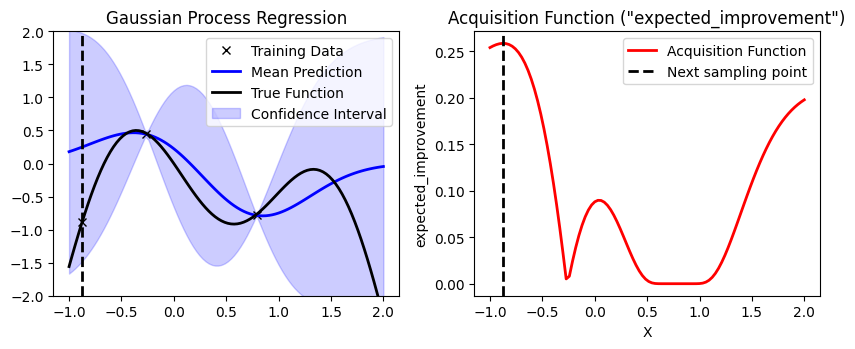

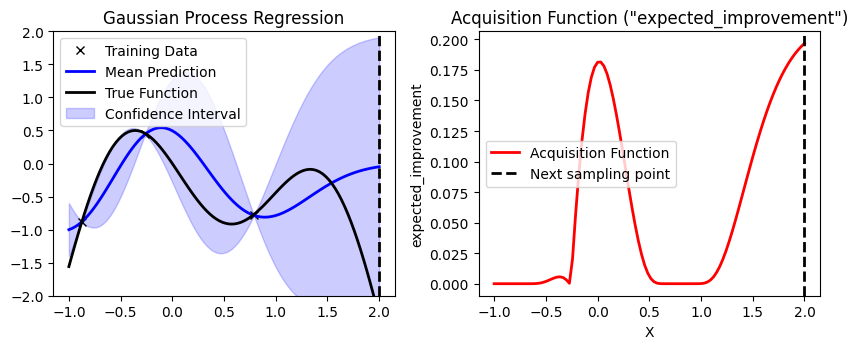

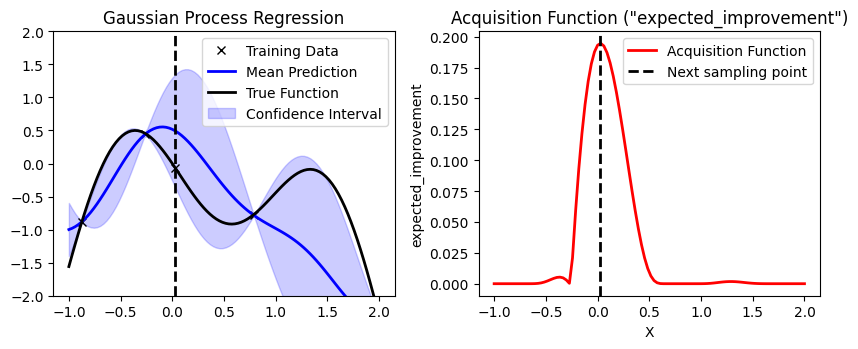

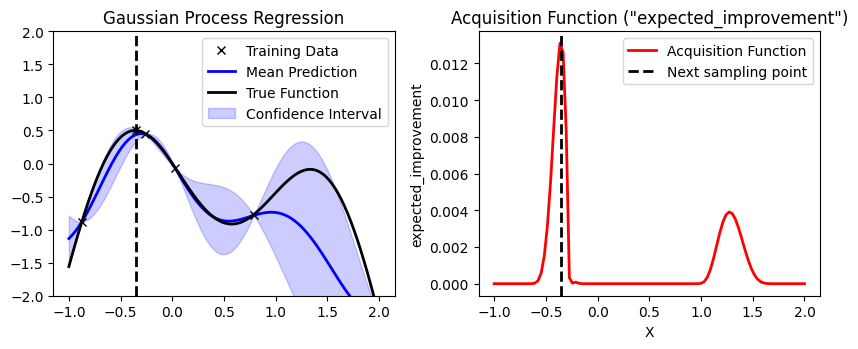

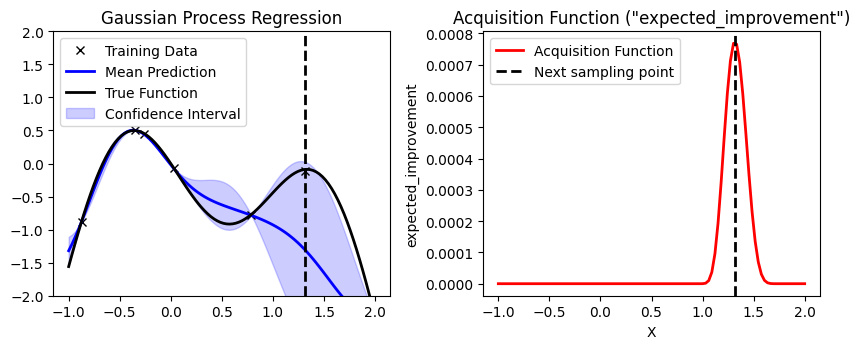

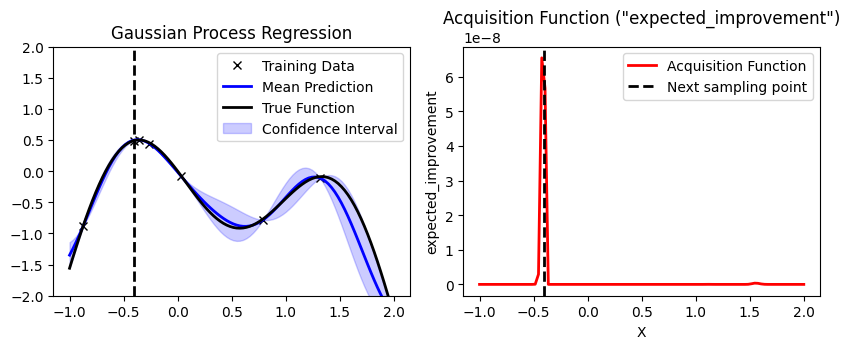

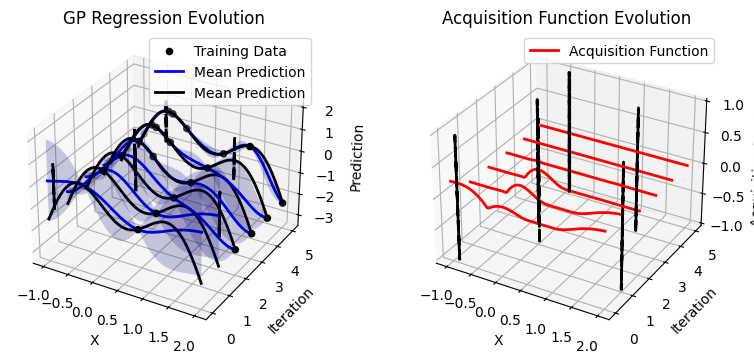

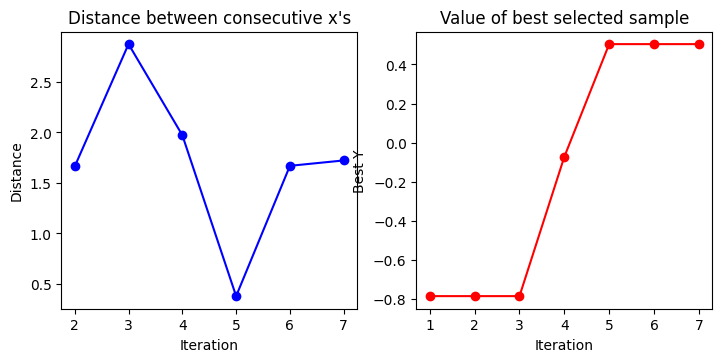

In [9]:
def pipeline(name="expected_improvement", iter=6, insight=False):
    np.random.seed(12345678)
    n_samples = 2
    bounds = np.array([[-1, 2]])
    X_train, y_train = generate_data(black_box_function=black_box_function, range = [bounds[:,0],bounds[:,1]], n_samples=n_samples,noise=0.01)
    noise = 0.01
    gpr = GaussianProcessRegression(length_scale=0.5)
    gpr.fit(X_train=X_train,y_train=y_train)
    acquisition_function = AcquisitionFunction()
    expected_improvement = acquisition_function.get_function(name=name)

    bayesian_optimization = BayesianOptimization(black_box_function=black_box_function, gpr=gpr, acquisition_function=expected_improvement, 
                                                 bounds=bounds, noise=noise, name=name)
    bayesian_optimization.optimize(iter=iter,insight=insight)


if __name__ == "__main__":
    name = "expected_improvement"
    iter = 6
    insight = True
    pipeline(name=name,iter=iter, insight=insight)

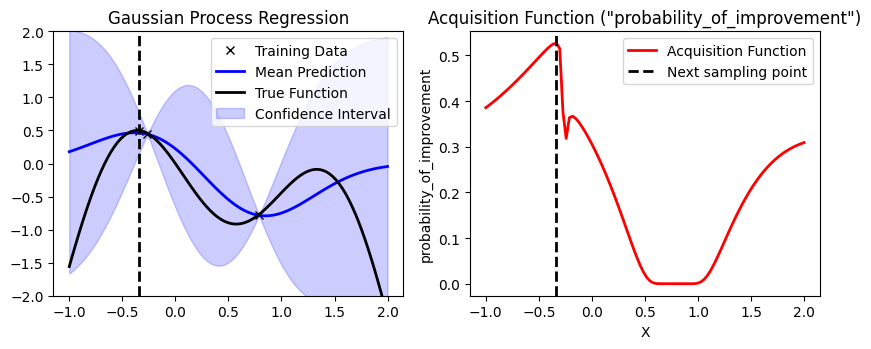

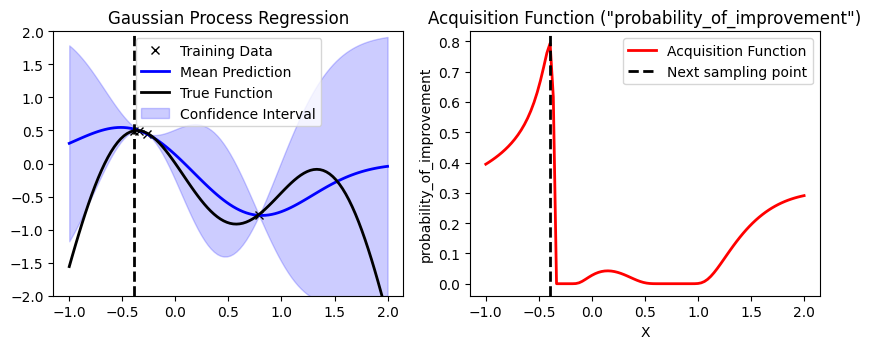

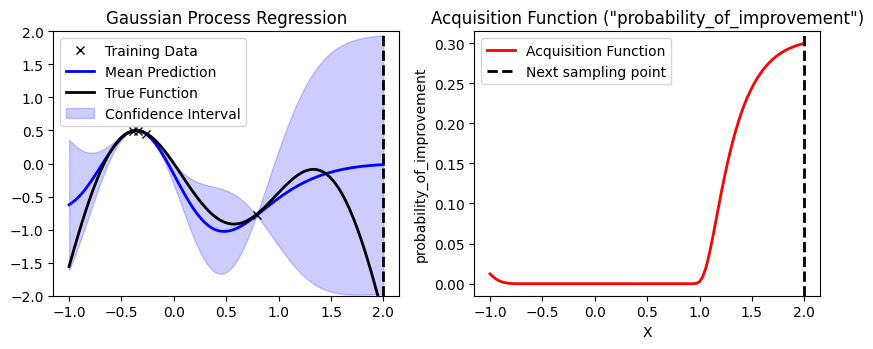

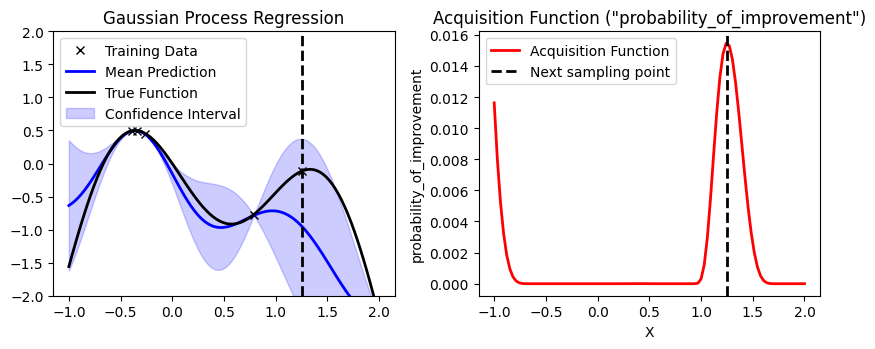

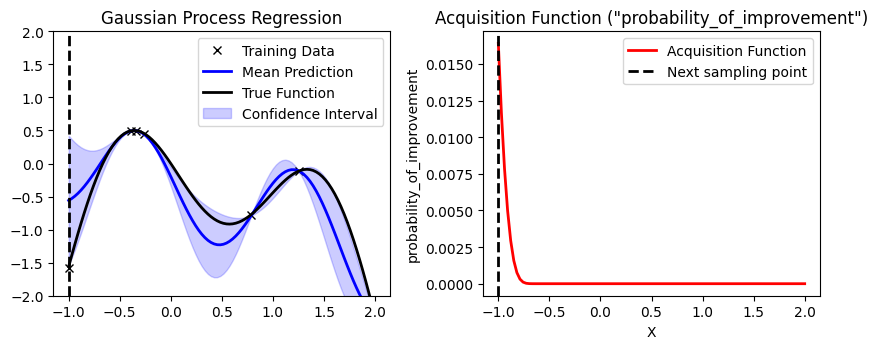

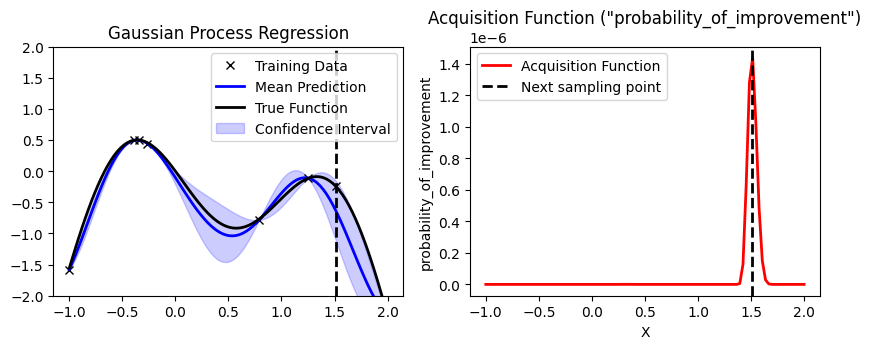

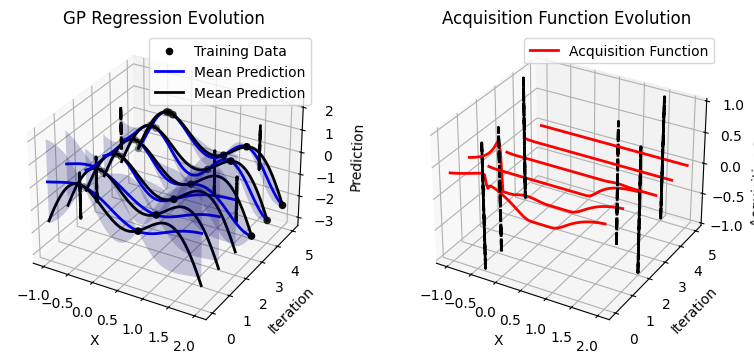

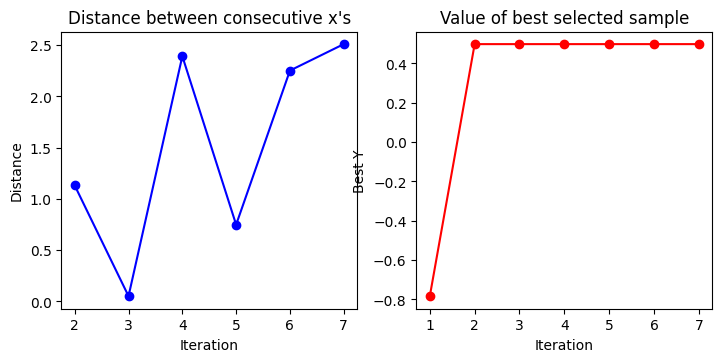

In [10]:
if __name__ == "__main__":
    name = "probability_of_improvement"
    iter = 6
    insight = True
    pipeline(name=name,iter=iter,insight=insight)

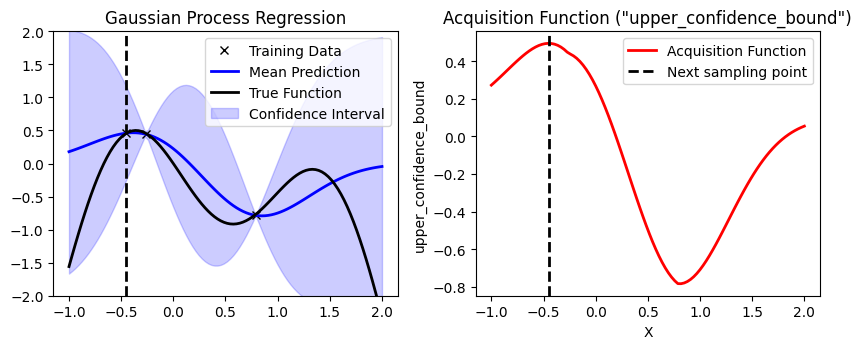

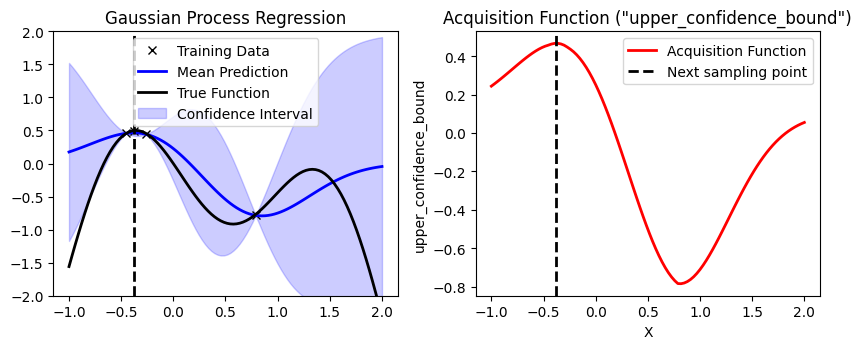

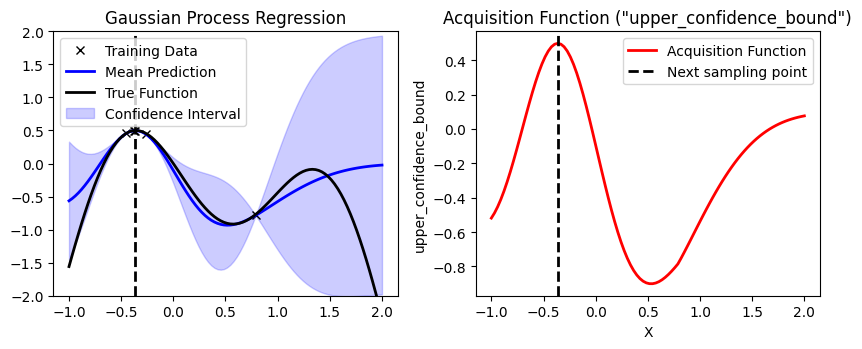

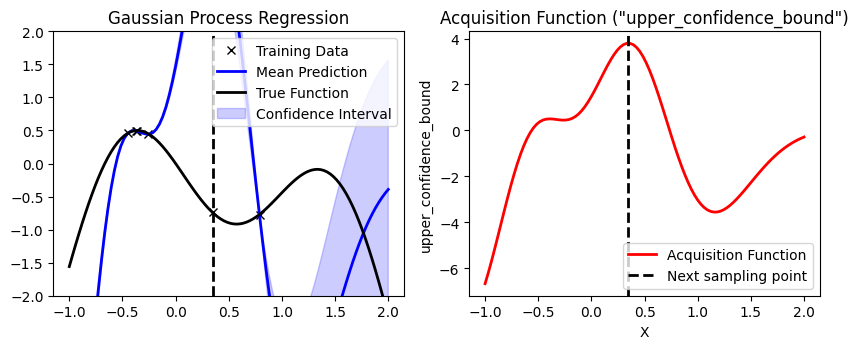

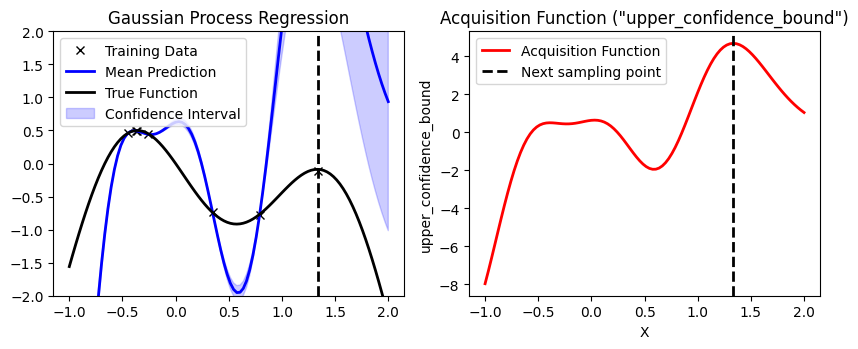

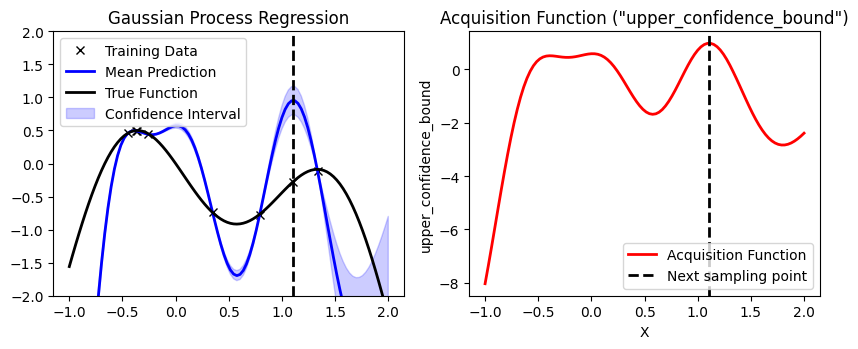

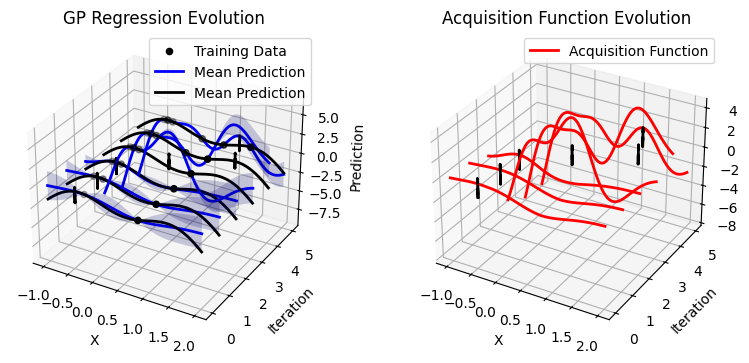

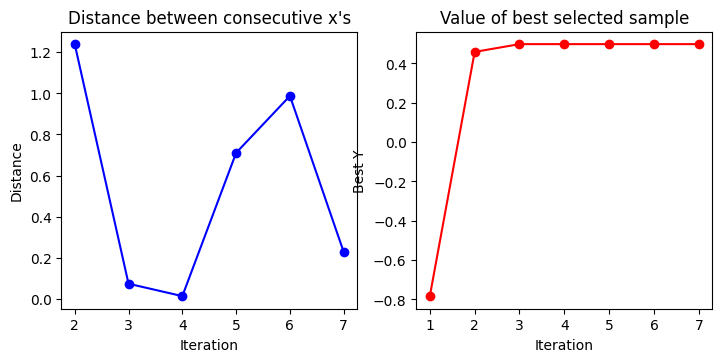

In [11]:
if __name__ == "__main__":
    name = "upper_confidence_bound"
    iter = 6
    insight = True
    pipeline(name=name,iter=iter,insight=insight)

<h1>Appendix</h1>

<h3> Probability of Improvement </h3>


1. Probability of the improvement greater than zero


$$
\begin{aligned}
\mathrm{PI}(\mathbf{x}) & =P\left(I(\mathbf{x}) \geq 0\right) 
\\
&= P\left(f\left(\mathbf{x}\right) \geq f\left(\mathbf{x}^{+}\right)\right)
\end{aligned}
$$


2. Reparametrization $f(x)$ and rewriting the inequality function


$$
\begin{aligned}
P\left(f\left(\mathbf{x}\right) \geq f\left(\mathbf{x}^{+}\right)\right)  &= P\left(\mu(x \mid \mathcal{D}) + \sigma(x \mid \mathcal{D}) z \geq f\left(\mathbf{x}^{+}\right)\right) 
\\
&= P\left( z \geq \frac{f\left(\mathbf{x}^{+})- \mu(x \mid \mathcal{D} \right )}{ \sigma(x \mid \mathcal{D}) }  \right)
\\
&= P\left( z \geq z_0  \right)
\end{aligned}
$$


$\phantom{===}$ where $z_0$ is equal to $\frac{f\left(\mathbf{x}^{+})- \mu(x \mid \mathcal{D} \right )}{ \sigma(x \mid \mathcal{D}) }$



3. Expressing property in CDF


$$
\begin{aligned}
P\left( z \geq z_0  \right) = 1 - \Phi(z_0)\\
= \Phi(-z_0)
\end{aligned}
$$


4. Conclusion


$$
\begin{aligned}
\mathrm{PI}(\mathbf{x}) & =P\left(I(\mathbf{x}) \geq 0\right)  =\Phi\left(\frac{\mu(\mathbf{x}\mid \mathcal{D})-f\left(\mathbf{x}^{+}\right)-\xi}{\sigma(\mathbf{x}\mid \mathcal{D})}\right)
\end{aligned}
$$


- Both Probability of Improvement (PI) and Expected Improvement (EI) require integrating over a Gaussian distribution. In the univariate case, the problem is significantly simpler, allowing for an analytical solution to be readily found. For multivariate cases, however, numerical methods such as Gaussian quadrature are often used to approximate the integral.

<h3> Expected Improvement </h3>

1. The expected value of the improvement function
$$
\mathrm{EI}(\mathbf{x}) = \mathbb{E}\left( I(\mathbf{x}) \mid \mathcal{D}\right) = \mathbb{E}\left(\max \left\{0, f(\mathbf{x})-f\left(\mathbf{x}^{+}\right)\right\} \mid \mathcal{D}\right)
$$

2. Integration to obtain the expected value, and removing the max_operator by splitting at $z_0 = \frac{f\left(\mathbf{x}^{+})- \mu(x \mid \mathcal{D} \right )}{ \sigma(x \mid \mathcal{D}) }$. For $z < z_0$, the improvement function gives 0.

$$
\begin{aligned}
\mathbb{E}\left( I(\mathbf{x}) \mid \mathcal{D}\right) &= \int_{-\infty}^{\infty} I(x) \phi(z) \mathrm{d}z 
\\
&= \int_{z_0}^{\infty} \left(\max \left\{0, f(\mathbf{x})-f\left(\mathbf{x}^{+}\right)\right\} \mid \mathcal{D}\right) \phi(z) \mathrm{d}z
\\
&= \int_{-\infty}^{z_0} 0 * \phi(z) \mathrm{d}z  + \int_{z_0}^{\infty} \left(f(\mathbf{x})-f\left(\mathbf{x}^{+}\right)\right) \phi(z) \mathrm{d}z 
\\
&= \int_{z_0}^{\infty} \left(\mu(x \mid \mathcal{D}) + \sigma(x \mid \mathcal{D}) z-f\left(\mathbf{x}^{+}\right)\right) \phi(z) \mathrm{d}z 
\end{aligned}
$$

3. More mathematical gymnastics and substituting $\phi(z) = \frac{1}{\sqrt{2 \pi}} e^{-z^2 / 2}$

$$
\begin{aligned}

\int_{z_0}^{\infty} \left(\mu(x \mid \mathcal{D}) + \sigma(x \mid \mathcal{D}) z-f\left(\mathbf{x}^{+}\right)\right) \phi(z) \mathrm{d}z 
&=
\int_{z_0}^{\infty} \left(\mu(x \mid \mathcal{D})-f\left(\mathbf{x}^{+}\right)\right) \phi(z) \mathrm{d}z 
+
\int_{z_0}^{\infty} \left(\sigma(x \mid \mathcal{D}) z\right) \phi(z) \mathrm{d}z
\\
&=\left(\mu(x \mid \mathcal{D})-f\left(\mathbf{x}^{+}\right)\right)  \int_{z_0}^{\infty} \phi(z) \mathrm{d}z 
+
\sigma(x \mid \mathcal{D})\int_{z_0}^{\infty}  z \frac{1}{\sqrt{2 \pi}} e^{-z^2 / 2} \mathrm{d}z
\\
&=\left(\mu(x \mid \mathcal{D})-f\left(\mathbf{x}^{+}\right)\right)  \Phi(-z_0)
-
\sigma(x \mid \mathcal{D})\int_{z_0}^{\infty} \frac{1}{\sqrt{2 \pi}} e^{-z^2 / 2} \mathrm{d}(-z^2/2)
\\
&=\left(\mu(x \mid \mathcal{D})-f\left(\mathbf{x}^{+}\right)\right)  \Phi(-z_0)
+
\sigma(x \mid \mathcal{D})\phi(z_0)
\end{aligned}
$$


4. Conclusion

$$
\mathrm{EI}(\mathbf{x}) = \begin{cases} 
(\mu(\mathbf{x}\mid \mathcal{D}) - f(\mathbf{x}^+) - \xi)\Phi(Z) + \sigma(\mathbf{x}\mid \mathcal{D})\phi(Z) & \text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) > 0 \\ 
0 & \text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) = 0 
\end{cases}
$$


where

$$
Z =
\begin{cases}
\frac{\mu(\mathbf{x}\mid \mathcal{D}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x}\mid \mathcal{D})} &\text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}\mid \mathcal{D}) = 0
\end{cases}
$$